In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import userdata

## Datasets

[ADE20K](https://www.kaggle.com/datasets/ipythonx/ade20k-scene-parsing)
- Image : jpg
- Mask : PNG


- - - -
**헷갈리는 점..
train, val은 Crop,
Test는 Resize..
뭔가 안맞을것 같은데..**

In [ ]:
try:
    os.environ['KAGGLE_USERNAME'] = "ENTER_YOUR_USERNAME_HERE"
    os.environ['KAGGLE_KEY'] = 'ENTER_YOUR_KEY_HERE'
    print("User info being set")

    !kaggle datasets download -d ipythonx/ade20k-scene-parsing
    !unzip -q ade20k-scene-parsing.zip -d ade20k_data

    print("Dataset Download and Unzip Complete")
except:
    print("User info has not been set.")


User info being set
Dataset URL: https://www.kaggle.com/datasets/ipythonx/ade20k-scene-parsing
License(s): copyright-authors
100% 1.10G/1.10G [00:16<00:00, 202MB/s]
100% 1.10G/1.10G [00:16<00:00, 70.3MB/s]
Dataset Download and Unzip Complete


In [ ]:
head_path = '/content/ade20k_data'
print(os.listdir(head_path))

['ADEChallengeData2016', 'release_test']


In [ ]:
image_path = os.path.join(head_path, "ADEChallengeData2016/images")
mask_path = os.path.join(head_path, "ADEChallengeData2016/annotations")

print(os.listdir(image_path))

num_train_img = len(os.listdir(os.path.join(image_path, 'training')))
num_val_img = len(os.listdir(os.path.join(image_path, 'validation')))
num_test_img = len(os.listdir(os.path.join(head_path, 'release_test/testing')))

print(f"train 이미지 데이터 수 : {num_train_img}")
print(f"Validation 이미지 데이터 수 : {num_val_img}")
print(f"Test 이미지 데이터 수 : {num_test_img}")

['validation', 'training']
train 이미지 데이터 수 : 20210
Validation 이미지 데이터 수 : 2000
Test 이미지 데이터 수 : 3352


In [ ]:
import os
from PIL import Image

training_dir = os.path.join(image_path, "training")

image_files = [
    f for f in os.listdir(training_dir)
    if f.lower().endswith(".jpg")
]

smallest_h = float("inf")
smallest_w = float("inf")

for image_file in image_files:
    img_path = os.path.join(training_dir, image_file)

    with Image.open(img_path) as img:
        w, h = img.size  # (width, height)

        if h < smallest_h:
            smallest_h = h
        if w < smallest_w:
            smallest_w = w

print(f"Smallest Height : {smallest_h}")
print(f"Smallest Width  : {smallest_w}")

Smallest Height : 96
Smallest Width  : 130


Image format : JPEG
Image size : (300, 225)
Image mode : RGB


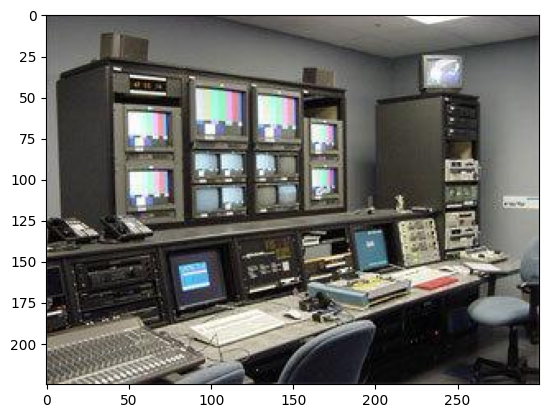

In [ ]:
image_files = os.listdir(os.path.join(image_path, "training"))
image_files = [f for f in image_files if f.lower().endswith("jpg")]

first_image_file = image_files[0]
first_image_path = os.path.join(os.path.join(image_path, "training"), first_image_file)
img = Image.open(first_image_path)
plt.imshow(img)
print(f"Image format : {img.format}")
print(f"Image size : {img.size}")
print(f"Image mode : {img.mode}")

In [28]:
train_transform = transforms.Compose([
    # train_transform은 다양성을 위한 무작위 변환에 초점을 맞춤.
    # 224가 작다는 이야기가 있음.. 384, 473 중에서 다시 해보기
    transforms.RandomCrop(224, pad_if_needed=True, padding_mode='constant', fill=0),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [26]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mode='train', transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.mode = mode

        self.img_folder = os.path.join(self.image_dir, 'images', mode)
        self.mask_folder = os.path.join(self.image_dir, 'annotations', mode)

        self.img_files = sorted(os.listdir(self.img_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))

    def __len__ (self):
        return len(self.img_files)

    def __getitem__(self, index):
        image = Image.open(os.path.join(self.img_foler, self.img_files[index]))
        image = image.convert('RGB')

        mask = Image.open(os.path.join(self.mask_folder, self.mask_files[index]))
        mask = mask.convert('L')

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [34]:
class TestDataset(Dataset):
    def __init__(self, image_dir, mode, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        self.img_folder = os.path.join(self.image_dir, mode)
        self.img_files = sorted(os.listdir(self.img_folder))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_name = self.image_files[index]
        image_path = os.path.join(self.img_foler, img_name)
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, img_name

In [35]:
train_dataset = CustomDataset(image_dir=os.path.join(head_path, 'ADEChallengeData2016'), mode='training', transform=train_transform)
val_dataset = CustomDataset(image_dir = os.path.join(head_path, 'ADEChallengeData2016'), mode='validation', transform=test_transform)
test_dataset = TestDataset(image_dir = os.path.join(head_path, 'release_test'), mode='testing', transform=test_transform)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
class PSPN(nn.Module):
    def __init__(self, )